In [1]:
# plot distribution of emotion in a list of logits
# using the pre-computed logits in cache/ (obtained by running emotion_tree_get_logits.py)

# from nnsight import CONFIG
from nnsight import LanguageModel
# import os
import numpy as np
import pickle
import torch
import more_itertools
from collections import defaultdict
from collections import Counter

import re

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# define the following wrapper class so that we can pickle the nested defaultdict
class DefaultDictWrapper:
    @staticmethod
    def zero():
        return int()

    @staticmethod
    def inner_defaultdict():
        return defaultdict(DefaultDictWrapper.zero)

In [2]:
# load emotion words and add a space in front of each of them
with open('data/emotion_wheel_SSKO.pkl', 'rb') as f:
    SSKO, _, _ = pickle.load(f)
emotion_words = list(more_itertools.collapse(SSKO[1]))
print(emotion_words)
# for i in range(len(emotion_words)):
#     emotion_words[i] = " " + emotion_words[i].lower()

# prompts and models
prompt_name = 'emotional_sentence_chatgpt4_5000'
filename_list = ['gpt2', 'llama-8', 'llama-70', 'llama-405']
model_name_list = ['gpt2', 'meta-llama/Meta-Llama-3.1-8B', 'meta-llama/Meta-Llama-3.1-70B', 'meta-llama/Meta-Llama-3.1-405B']

# filename_list = ['gpt2']
# model_name_list = ['gpt2']


['adoration', 'affection', 'fondness', 'liking', 'attraction', 'caring', 'tenderness', 'compassion', 'sentimentality', 'arousal', 'desire', 'lust', 'passion', 'infatuation', 'longing', 'amusement', 'bliss', 'cheerfulness', 'gaiety', 'glee', 'jolliness', 'joviality', 'delight', 'enjoyment', 'gladness', 'happiness', 'jubilation', 'elation', 'satisfaction', 'ecstasy', 'euphoria', 'enthusiasm', 'zeal', 'zest', 'excitement', 'thrill', 'exhilaration', 'contentment', 'pleasure', 'pride', 'triumph', 'eagerness', 'hope', 'optimism', 'enthrallment', 'rapture', 'relief', 'amazement', 'astonishment', 'aggravation', 'irritation', 'agitation', 'annoyance', 'grouchiness', 'grumpiness', 'exasperation', 'frustration', 'rage', 'outrage', 'fury', 'wrath', 'hostility', 'ferocity', 'bitterness', 'hate', 'loathing', 'scorn', 'spite', 'vengefulness', 'dislike', 'resentment', 'disgust', 'revulsion', 'contempt', 'envy', 'jealousy', 'torment', 'agony', 'suffering', 'hurt', 'anguish', 'depression', 'despair', 'h

/Users/bozhao/anaconda3/envs/ntt5/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1602: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


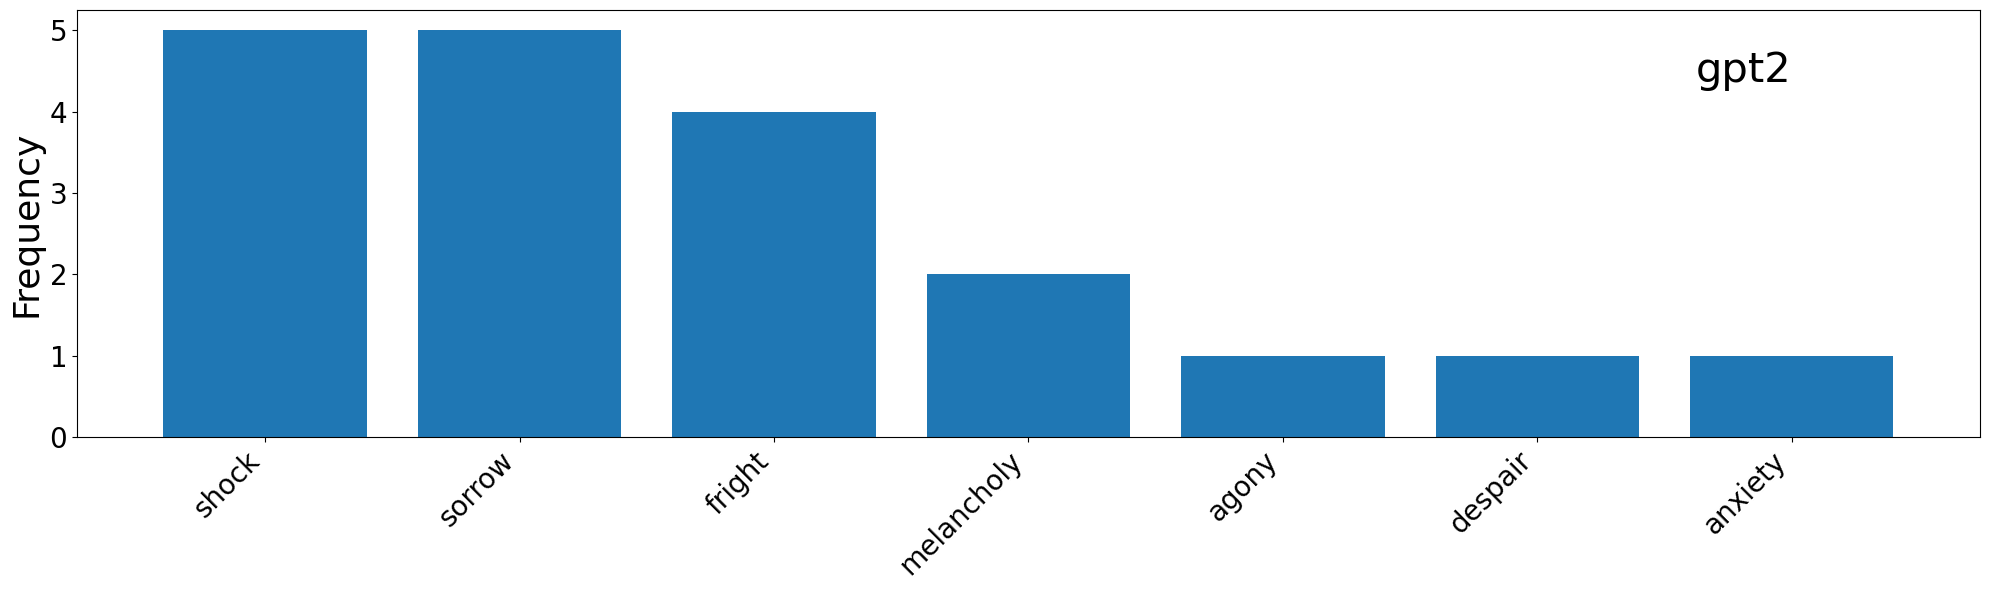

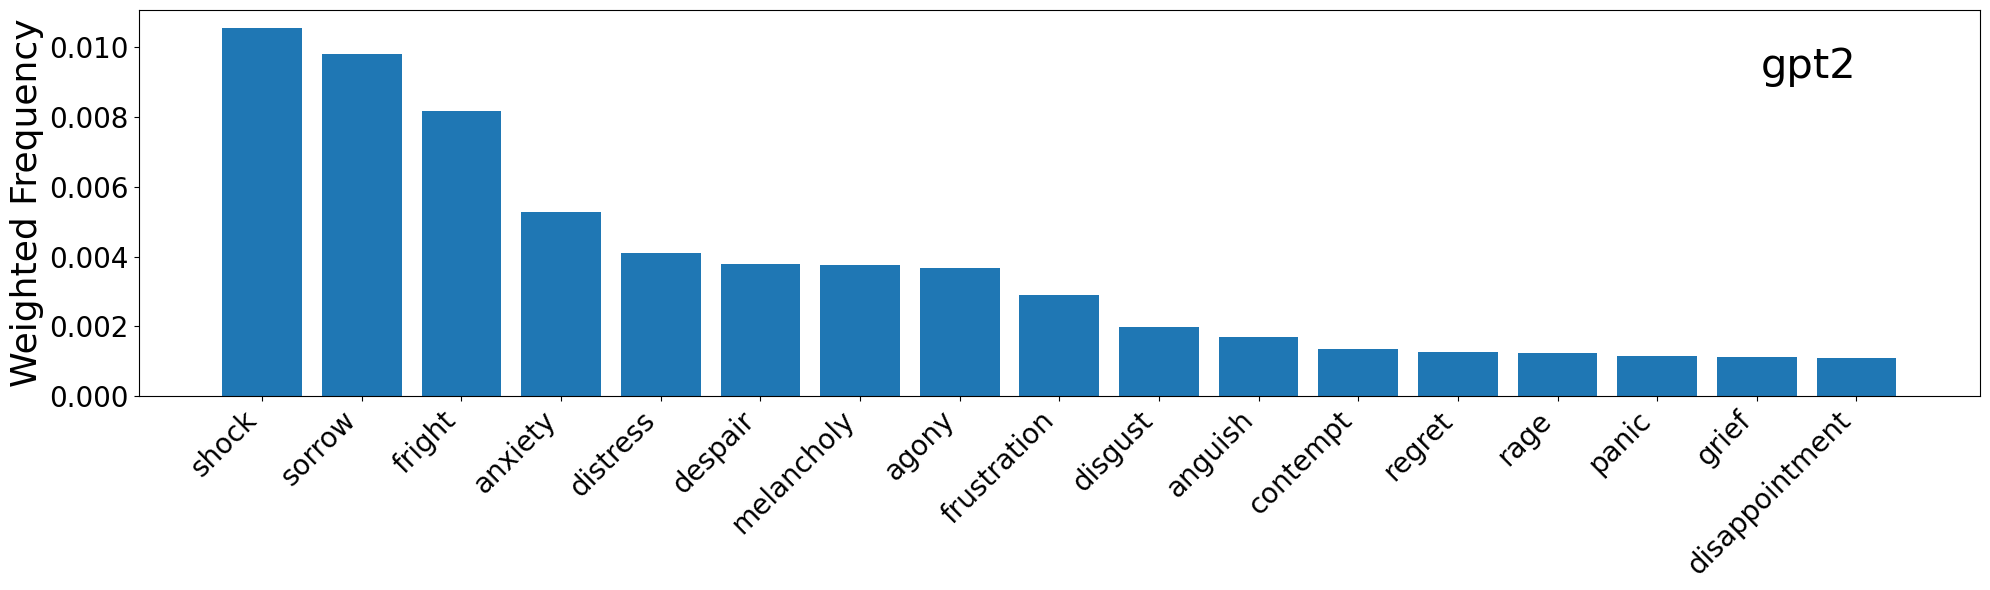

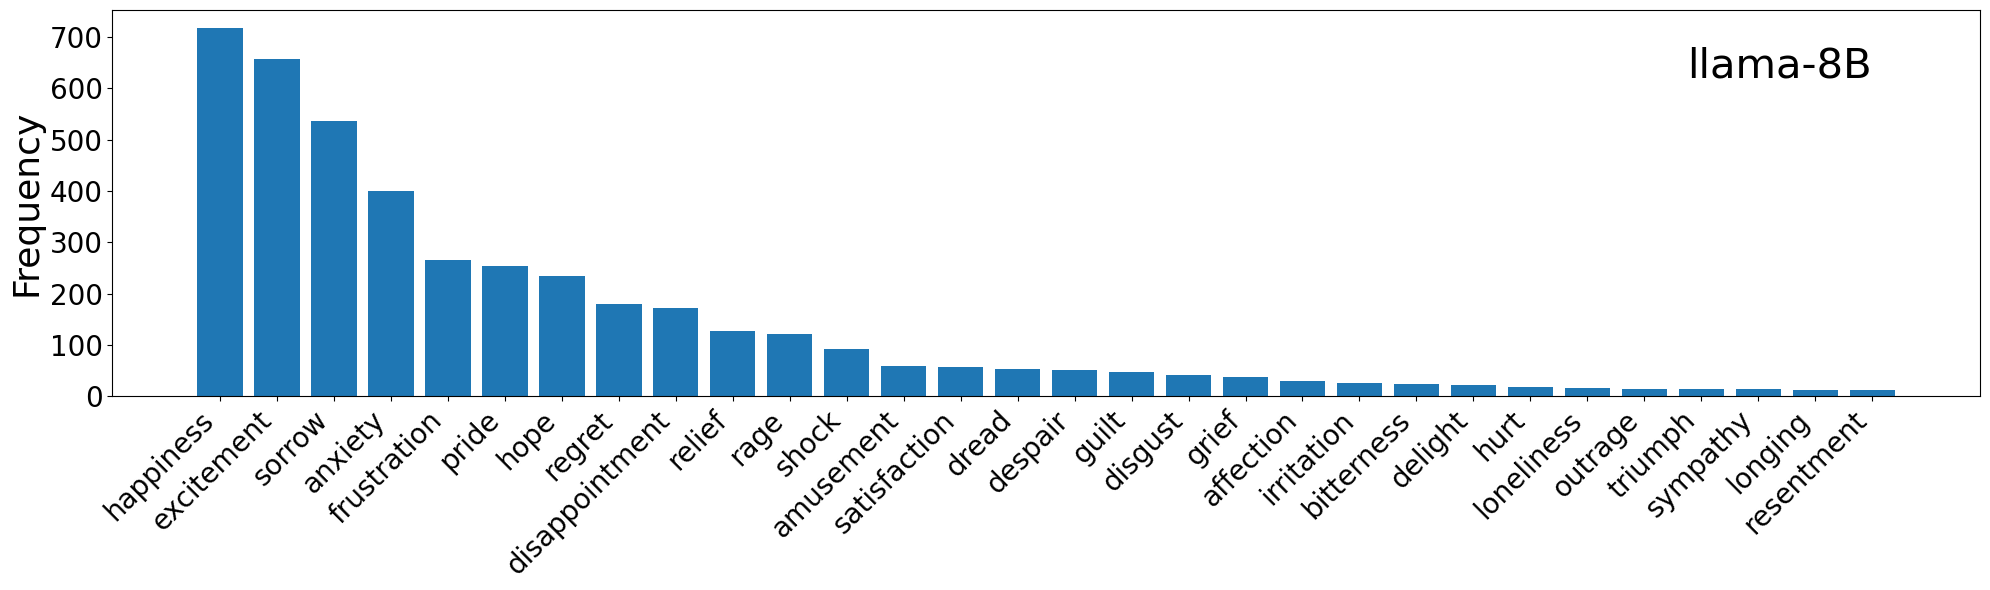

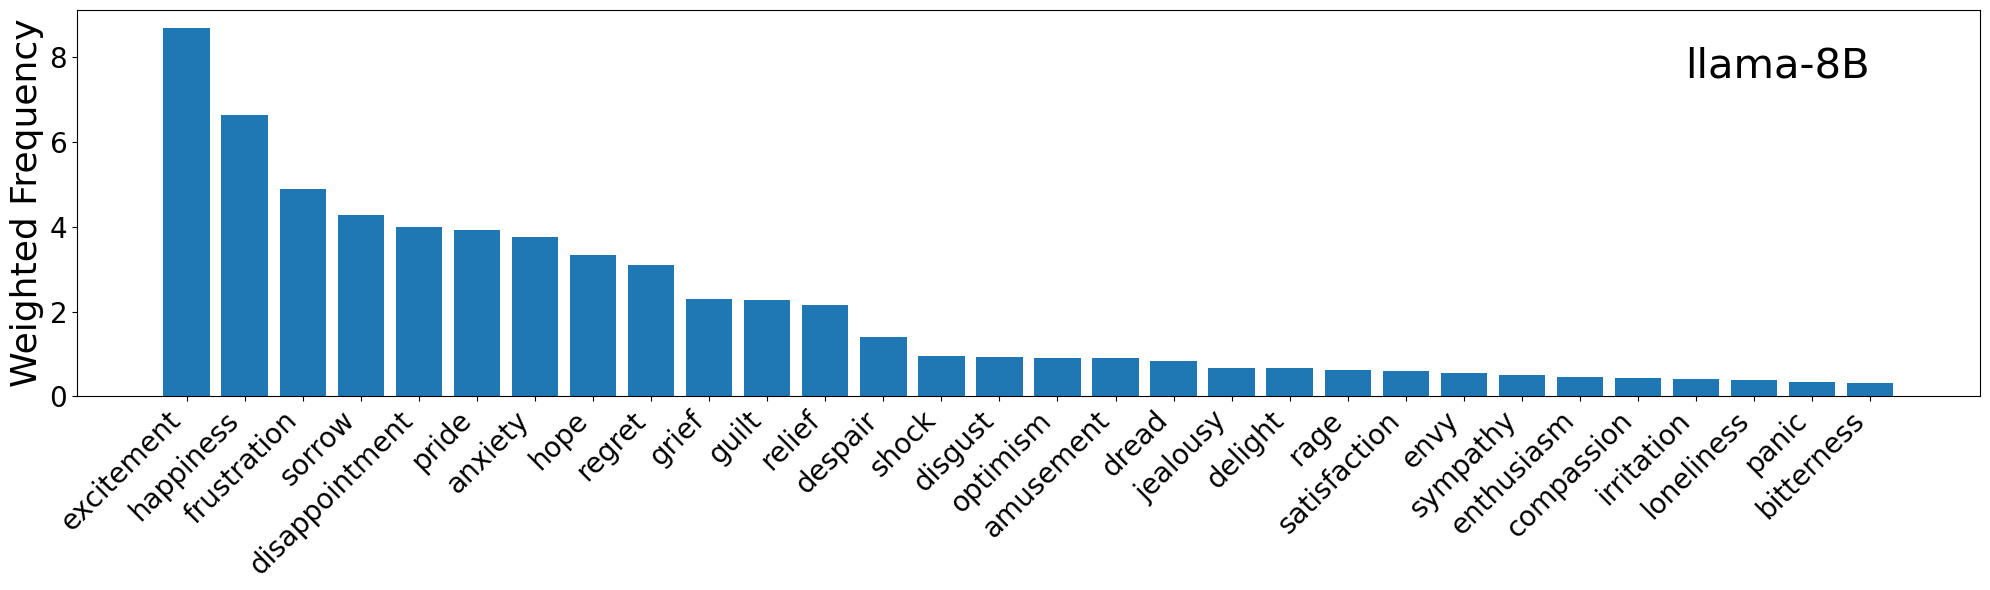

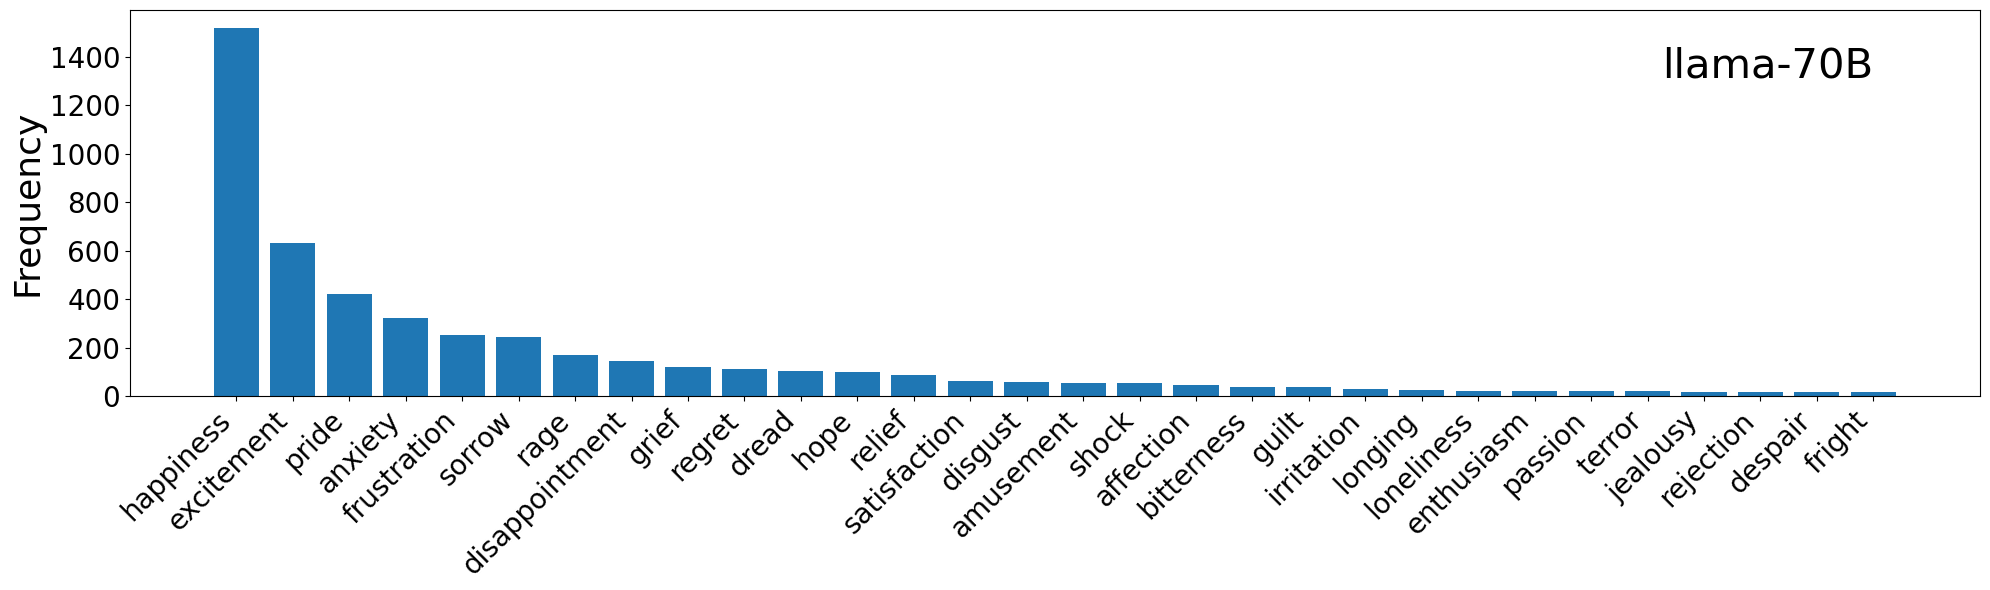

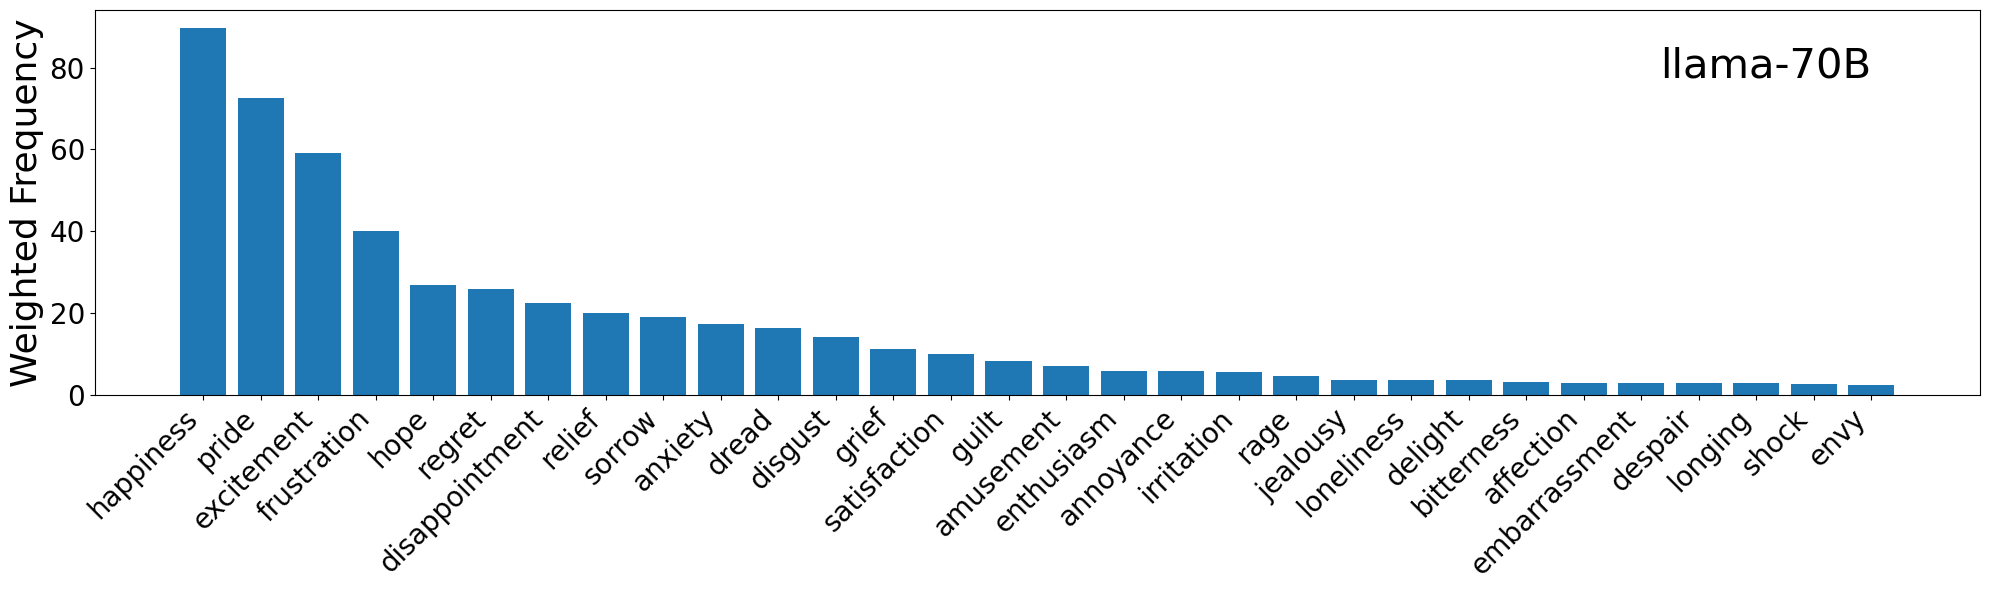

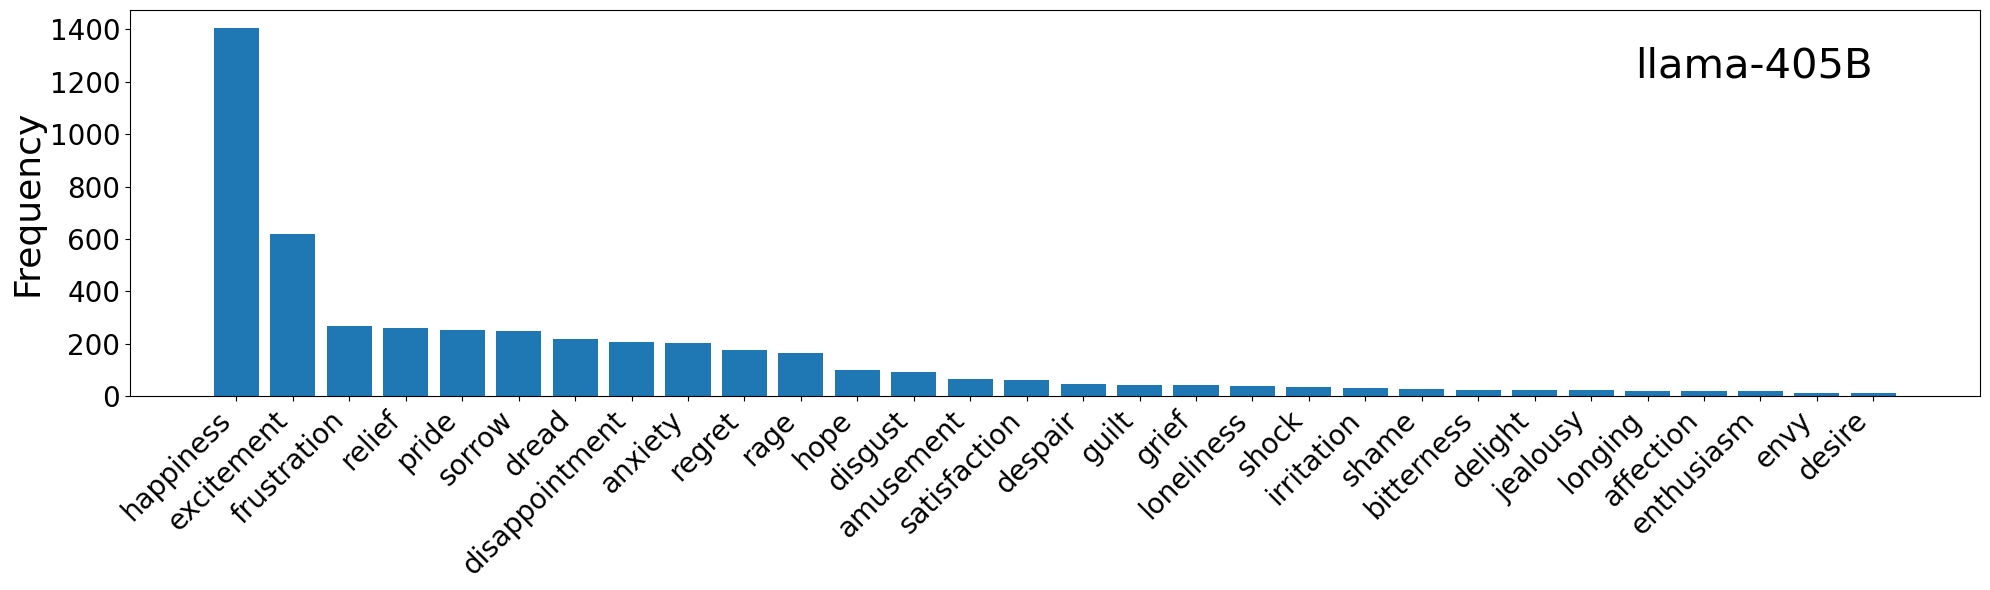

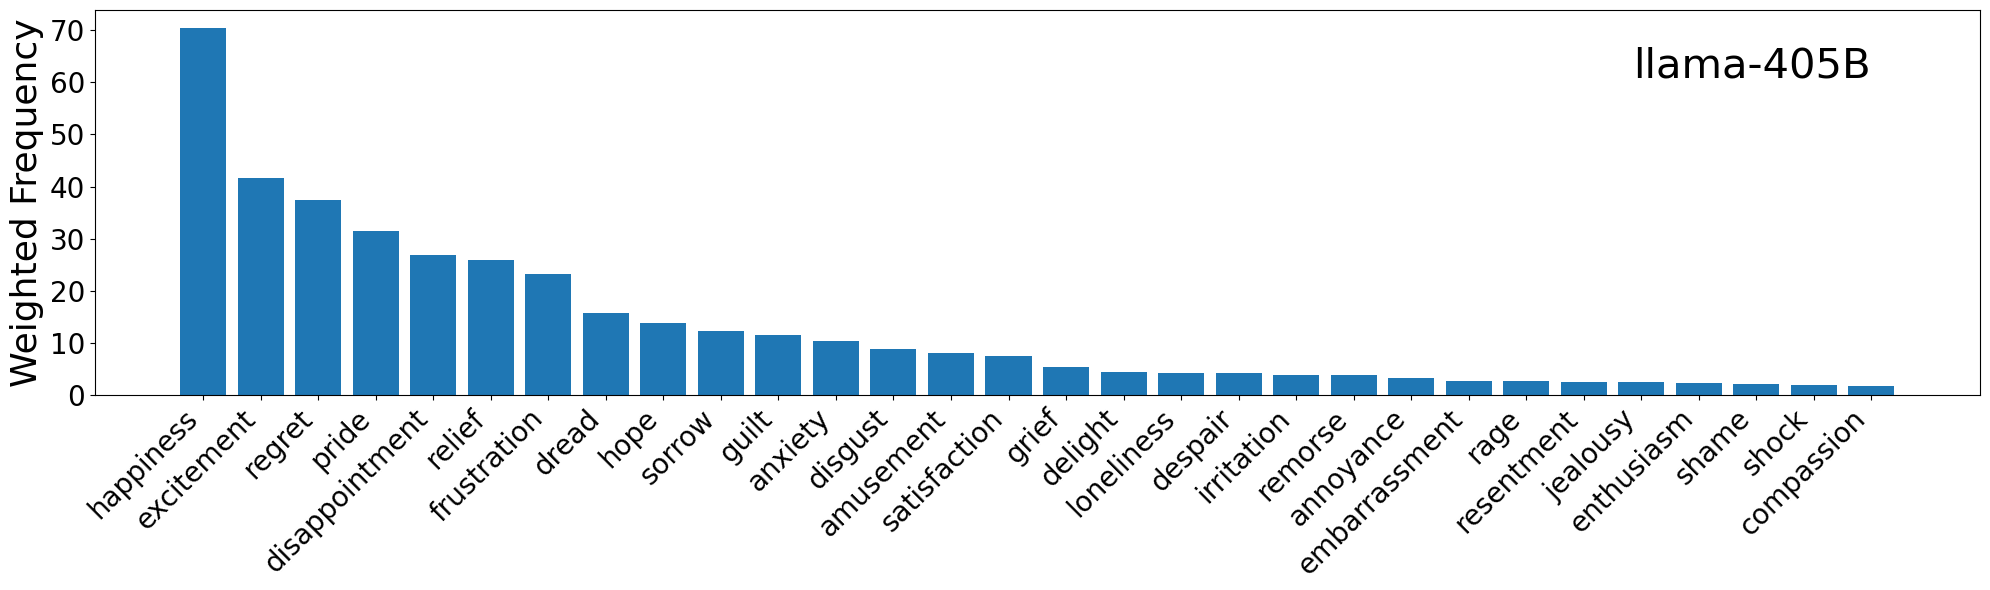

In [7]:
# for each model, use logits to compute co-occurence matrix
for filename, model_name in zip(filename_list, model_name_list):
    with open('cache/hidden_states_{}/{}_logits_list.pkl'.format(filename, prompt_name), 'rb') as f:
        logits_list = pickle.load(f) # size 5000 x 128256

    model = LanguageModel(model_name, device_map="auto")

    # Find the top 100 probability and corresponding tokens for each prompt
    max_probs_list = []
    tokens_list = []
    words = []
    for i in range(len(logits_list)):
        max_probs, tokens = logits_list[i].topk(100, largest=True, dim=-1) # [0, 1], int
        max_probs_list.append(max_probs)
        tokens_list.append(tokens)
        word_str = [model.tokenizer.decode(t).encode("unicode_escape").decode() for t in tokens][0]
        word_list = re.findall(r"'\s*|\w+", word_str) #word_str.split()
        words.append(word_list)
        # print(max_probs.sum()) # should be close to 1

    max_probs = torch.cat(max_probs_list) # size 5000 x 100
    tokens = torch.cat(tokens_list) # size 5000 x 100

    ########################################################################################
    # List to store the first emotion word found in each list of words
    first_emotion_words = []
    
    # Iterate over each list of words
    for word_list in words:
        # Find the first word in the list that is in emotion_words
        first_emotion = next((word for word in word_list if word in emotion_words), None)
        # Add it to the result if found
        if first_emotion:
            first_emotion_words.append(first_emotion)
    
    # Count the occurrences of each first emotion word
    word_frequencies = Counter(first_emotion_words)
    
    # Sort the word frequencies in descending order and select the top 20
    most_common_words = word_frequencies.most_common(30)
    
    # Separate words and their counts for plotting
    words_to_plot, frequencies_to_plot = zip(*most_common_words)
    
    # Create a wider figure (width=12, height=6 for example)
    plt.figure(figsize=(20, 6))
    
    # Plot a sorted histogram of the top 20 most frequent emotion words
    plt.bar(words_to_plot, frequencies_to_plot)
    plt.xticks(rotation=45, ha='right', fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel('Frequency', fontsize=26)
    # plt.title('Top 20 Most Frequent First Emotion Words')

    # Add text to the upper-right corner (coordinates will adjust based on data)
    if filename[0] == 'l':
        filename = filename + 'B'
    plt.text(len(words_to_plot) - 1, max(frequencies_to_plot) * 0.95, filename, 
         fontsize=30, ha='right', va='top', color='black')

    plt.tight_layout()  # Adjust layout so everything fits nicely
    plt.savefig('figures/bias/histogram_top_1_{}_{}.pdf'.format(prompt_name, filename), dpi=400, bbox_inches='tight')

    ########################################################################################
    # Dictionary to accumulate the sum of probabilities for each emotion word
    emotion_word_prob_sums = defaultdict(float)
    
    # Iterate over each list of words and corresponding probabilities
    for i, word_list in enumerate(words):
        probs = max_probs[i]  # Get the corresponding probabilities for this word list
        # Iterate through the word list and accumulate probabilities for emotion words
        for j, word in enumerate(word_list):
            if word in emotion_words:
                emotion_word_prob_sums[word] += probs[j].item()  # Convert tensor value to float and accumulate
    
    # Prepare data for plotting (sorted by summed probabilities)
    sorted_emotion_words = sorted(emotion_word_prob_sums.items(), key=lambda x: x[1], reverse=True)
    
    # Slice the top 30 emotions
    top_30_emotions = sorted_emotion_words[:30]
    words_to_plot, summed_probabilities_to_plot = zip(*top_30_emotions)
    
    # Create a wider figure
    plt.figure(figsize=(20, 6))
    
    # Plot the histogram where the frequency is the sum of probabilities
    plt.bar(words_to_plot, summed_probabilities_to_plot)
    
    # Set labels and title with larger font size
    plt.ylabel('Weighted Frequency', fontsize=26)
    # plt.title('Top 30 Emotion Words by Summed Probabilities', fontsize=18)
    
    # Rotate x-tick labels for better readability
    plt.xticks(rotation=45, ha='right', fontsize=20)
    plt.yticks(fontsize=20)

    # Add text to the upper-right corner (coordinates will adjust based on data)
    plt.text(len(words_to_plot) - 1, max(summed_probabilities_to_plot) * 0.95, filename, 
         fontsize=30, ha='right', va='top', color='black')
    
    # Display the plot
    plt.tight_layout()
    plt.savefig('figures/bias/histogram_top_100_summed_probabilities_{}_{}.pdf'.format(prompt_name, filename), dpi=400, bbox_inches='tight')




In [25]:
print(len(words_to_plot))

20
